Import trick

In [1]:
import sys
sys.path.insert(0, '..')

In [2]:
# Basic imports
import jax.numpy as np
import jax.random as jr
import jax.scipy as jsp
import jax
import numpy

#jax.config.update("jax_enable_x64", True)

# Optimisation imports
import zodiax as zdx
import optax

# dLux imports
import dLux as dl
import dLux.utils as dlu

# Visualisation imports
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib

plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72

from detectors import *
from apertures import *
from models import *
from fisher import *
from stats import posterior

# the real world
from astropy.io import fits
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS
from astrocut import fits_cut
from astropy.nddata import Cutout2D

import pandas as pd

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 72
plt.rcParams["font.size"] = 24

data

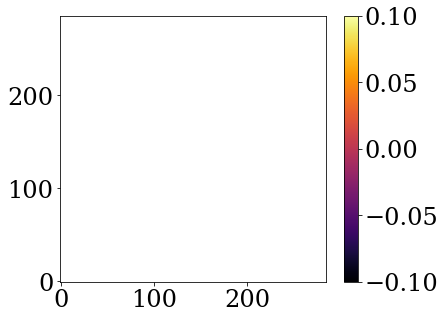

In [3]:
ddir = '../data/MAST_2024-07-11T09_26_05.575Z/'
fname_095 = ddir + 'HST/N43CA5020/n43ca5020_mos.fits'
fname_108 = ddir + 'HST/N43C03020/n43c03020_mos.fits'
fname_187 = ddir + 'HST/N43C03010/n43c03010_mos.fits'
fname_190 = ddir + 'HST/N43CA5010/n43ca5010_mos.fits'

#ddir = '../data/MAST_2024-07-07T03_17_36.223Z/'
#fname_095 = ddir + 'HST/n8ku01050_mos.fits'

wid = 64

exposure_095 = exposure_from_file(fname_095, SinglePointFit(), wid)
exposure_108 = exposure_from_file(fname_108, SinglePointFit(), wid)
exposure_187 = exposure_from_file(fname_187, SinglePointFit(), wid)
exposure_190 = exposure_from_file(fname_190, SinglePointFit(), wid)

exposures_s = [exposure_095]#,exposure_108, exposure_187]

exposure_095 = exposure_from_file(fname_095, BinaryFit(), wid)
exposure_108 = exposure_from_file(fname_108, BinaryFit(), wid)
exposure_187 = exposure_from_file(fname_187, BinaryFit(), wid)
exposure_190 = exposure_from_file(fname_190, BinaryFit(), wid)

exposures_b = [exposure_095]#, exposure_108, exposure_187]

snr = exposure_190.data/exposure_190.err
plt.imshow(np.log10(snr))
plt.colorbar()

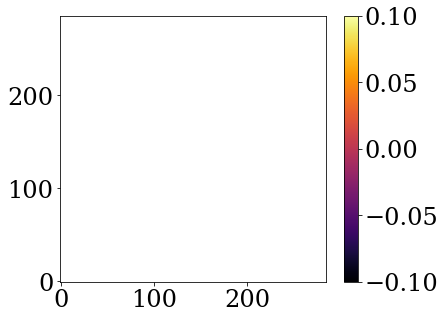

In [4]:
plt.imshow(exposure_190.data)
plt.colorbar()

(array([    0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0., 81796.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.,     0.,     0.,     0.,     0.,
            0.,     0.,     0.,     0.]),
 array([-0.5       , -0.49000001, -0.47999999, -0.47      , -0.46000001,
        -0.44999999, 

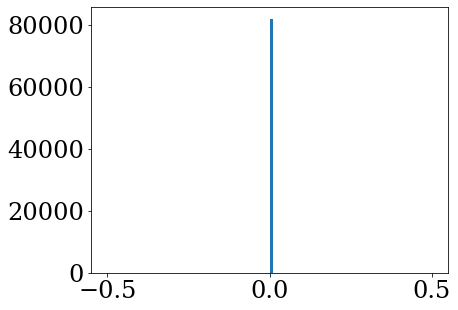

In [5]:
exp = exposure_190

err_test = np.where(exp.bad, 1, np.asarray(exp.err, dtype=float))
data_test = np.where(exp.bad, 1, np.asarray(exp.data, dtype=float))
plt.hist(np.log10(data_test.flatten()), bins=100)

models

In [6]:
oversample = 4

optics = NICMOSOptics(512, wid, oversample)

detector = NICMOSDetector(oversample, wid)

params_s = {
    "fluxes": {},
    "positions": {},
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([-0.05, -0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

params_b = {
    "fluxes": {},
    "positions": {},
    "contrast": {},
    "separation": dlu.arcsec2rad(0.042),
    "position_angle": 1.8607855,
    "aberrations": {},#np.zeros(8),#np.asarray([0,18,19.4,-1.4,-3,3.3,1.7,-12.2])*1e-9,
    "cold_mask_shift": {}, #np.asarray([0.05, 0.05]),
    "cold_mask_rot": {},#np.asarray([np.pi/4]),
    "outer_radius": 1.2*0.955,
    "secondary_radius": 0.372*1.2,
    "spider_width": 0.077*1.2,
}

for exp in exposures_s:
    params_s["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_s["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)
    params_s["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_s["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.08,-0.08])
    params_s["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

for exp in exposures_b:
    params_b["positions"][exp.fit.get_key(exp, "positions")] = np.asarray([0.,0.])
    params_b["fluxes"][exp.fit.get_key(exp, "fluxes")] = np.nansum(exp.data)/2
    params_b["contrast"][exp.fit.get_key(exp, "contrast")] = 0.3
    params_b["aberrations"][exp.fit.get_key(exp, "aberrations")] = np.zeros(8)
    params_b["cold_mask_shift"][exp.fit.get_key(exp, "cold_mask_shift")] = np.asarray([-0.08,-0.08])
    params_b["cold_mask_rot"][exp.fit.get_key(exp, "cold_mask_rot")] = np.pi/4

def set_array(pytree):
    dtype = np.float64 if jax.config.x64_enabled else np.float32
    floats, other = eqx.partition(pytree, eqx.is_inexact_array_like)
    floats = jtu.tree_map(lambda x: np.array(x, dtype=dtype), floats)
    return eqx.combine(floats, other)

point_model = set_array(NICMOSModel(exposures_s, params_s, optics, detector))
binary_model = set_array(NICMOSModel(exposures_b, params_b, optics, detector))
params_s = ModelParams(params_s)
params_b = ModelParams(params_b)

In [7]:

def scheduler(lr, start, *args):
    shed_dict = {start: 1e10}
    for start, mul in args:
        shed_dict[start] = mul
    return optax.piecewise_constant_schedule(lr / 1e10, shed_dict)

base_sgd = lambda vals: optax.sgd(vals, nesterov=True, momentum=0.6)

opt = lambda lr, start, *schedule: base_sgd(scheduler(lr, start, *schedule))

def flatten(l):
    if isinstance(l, (tuple, list)):
         return [a for i in l for a in flatten(i)]
    else:
        return [l]

g = 3e-2

things_single = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "cold_mask_shift": opt(g*300, 40),
    "cold_mask_rot": opt(g*80, 40),
    "aberrations": opt(g*0.6,70),
    #"outer_radius": opt(g*100, 90),
    #"secondary_radius": opt(g*100,90),
    #"spider_width": opt(g*50,90),
}

g = 2e-2

things_binary = {
    "fluxes" : opt(g*20,10),
    "positions": opt(g*10, 0),
    "separation": opt(g*10, 20),
    "contrast": opt(g*10, 20),
    "position_angle": opt(g*3, 20),
    "cold_mask_shift": opt(g*300,40),
    "cold_mask_rot": opt(g*80,40),
    "aberrations": opt(g*1,70),
    #"outer_radius": opt(g*100, 100),
    #"secondary_radius": opt(g*100,100),
    #"spider_width": opt(g*50,100),
}

groups_s = list(things_single.keys())
paths_s = flatten(groups_s)
optimisers_s = [things_single[i] for i in groups_s]
groups_s = [list(x) if isinstance(x, tuple) else x for x in groups_s]

groups_b = list(things_binary.keys())
paths_b = flatten(groups_b)
optimisers_b = [things_binary[i] for i in groups_b]
groups_b = [list(x) if isinstance(x, tuple) else x for x in groups_b]

In [8]:
@zdx.filter_jit
@zdx.filter_value_and_grad(paths_s)
def loss_fn_s(params,exposures):
    model = params.inject(point_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

@zdx.filter_jit
@zdx.filter_value_and_grad(paths_b)
def loss_fn_b(params,exposures):
    model = params.inject(binary_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

In [9]:
point_model

NICMOSModel(
  params={
    'aberrations':
    {'N8KU01050': f32[8]},
    'cold_mask_rot':
    {'N8KU01050': f32[]},
    'cold_mask_shift':
    {'N8KU01050': f32[2]},
    'fluxes':
    {'N8KU01050': f32[]},
    'outer_radius':
    f32[],
    'positions':
    {'N8KU01050': f32[2]},
    'secondary_radius':
    f32[],
    'spider_width':
    f32[]
  },
  filters={'F170M': f32[137,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f32[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=True,
            transformation=CoordTransform(
              translation=f32[2],
              rotation=f32[],
              compression=None,
              shear=None
            ),
            apertures={
              'outer':
              CircularAperture(
                normalise=False,
                transformation=None,
           

In [10]:
print(loss_fn_s(params_s, exposures_s))
print(loss_fn_b(params_b, exposures_b))

ValueError: Incompatible shapes for broadcasting: shapes=[(256, 256), (64, 64), (256, 256)]

In [ ]:
rc = False
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc)
lrs_s = calc_lrs(point_model, exposures_s, fishers_s, paths_s)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc)
lrs_b = calc_lrs(binary_model, exposures_b, fishers_b, paths_b)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

In [ ]:
lrs_s.params

{'aberrations': {'N43CA5020': Array([ 6.1554708e-22,  3.5132545e-22,  3.5068767e-22, -9.8598427e-21,
         -1.7934804e-21, -1.6304815e-21, -1.8281204e-21,  9.6042747e-22],      dtype=float32)},
 'cold_mask_rot': {'N43CA5020': Array(1.283816e-11, dtype=float32)},
 'cold_mask_shift': {'N43CA5020': Array([1.0415823e-11, 1.0594189e-11], dtype=float32)},
 'fluxes': {'N43CA5020': Array(-0.03471993, dtype=float32)},
 'outer_radius': None,
 'positions': {'N43CA5020': Array([-2.6626365e-22, -2.4554536e-22], dtype=float32)},
 'secondary_radius': None,
 'spider_width': None}

In [ ]:
optim_s, opt_state_s = zdx.get_optimiser(
    params_s, groups_s, optimisers_s
)


losses_s, models_s = [], []
for i in tqdm(range(100)):
    loss, grads = loss_fn_s(params_s,exposures_s)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs_s.params))
    updates, opt_state_s = optim_s.update(grads, opt_state_s)
    params_s = zdx.apply_updates(params_s, updates)

    models_s.append(params_s)
    losses_s.append(loss)

optim_b, opt_state_b = zdx.get_optimiser(
    params_b, groups_b, optimisers_b
)


losses_b, models_b = [], []
for i in tqdm(range(100)):
    loss, grads = loss_fn_b(params_b,exposures_b)
    grads = jtu.tree_map(lambda x, y: x * np.abs(y), grads, ModelParams(lrs_b.params))
    updates, opt_state_b = optim_b.update(grads, opt_state_b)
    params_b = zdx.apply_updates(params_b, updates)

    models_b.append(params_b)
    losses_b.append(loss)

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
params_s.params["spider_width"]

0.0924

In [ ]:


"""def psf_cold_mask_x(x):
    pp = params_s.params
    pp["cold_mask_shift"]["N43CA5020"] = np.asarray([x, -0.05])
    params = ModelParams(pp)
    p_m = params.inject(point_model)
    psf = exposures_s[0].fit(p_m,exposures_s[0])
    return psf

def psf_cold_mask_y(x):
    pp = params_s.params
    pp["cold_mask_shift"]["N43CA5020"] = np.asarray([-0.05, x])
    params = ModelParams(pp)
    p_m = params.inject(point_model)
    psf = exposures_s[0].fit(p_m,exposures_s[0])
    return psf

def psf_secondary(x):
    pp = params_s.params
    pp["spider_width"] = np.asarray([x])
    params = ModelParams(pp)
    p_m = params.inject(point_model)
    psf = exposures_s[0].fit(p_m,exposures_s[0])
    return psf"""

'def psf_cold_mask_x(x):\n    pp = params_s.params\n    pp["cold_mask_shift"]["N43CA5020"] = np.asarray([x, -0.05])\n    params = ModelParams(pp)\n    p_m = params.inject(point_model)\n    psf = exposures_s[0].fit(p_m,exposures_s[0])\n    return psf\n\ndef psf_cold_mask_y(x):\n    pp = params_s.params\n    pp["cold_mask_shift"]["N43CA5020"] = np.asarray([-0.05, x])\n    params = ModelParams(pp)\n    p_m = params.inject(point_model)\n    psf = exposures_s[0].fit(p_m,exposures_s[0])\n    return psf\n\ndef psf_secondary(x):\n    pp = params_s.params\n    pp["spider_width"] = np.asarray([x])\n    params = ModelParams(pp)\n    p_m = params.inject(point_model)\n    psf = exposures_s[0].fit(p_m,exposures_s[0])\n    return psf'

In [ ]:
"""cmap = matplotlib.colormaps['seismic']
img = jax.jacfwd(psf_cold_mask_x)(-0.05)
vm = np.max(np.abs(img))
plt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)
plt.colorbar()"""

"cmap = matplotlib.colormaps['seismic']\nimg = jax.jacfwd(psf_cold_mask_x)(-0.05)\nvm = np.max(np.abs(img))\nplt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)\nplt.colorbar()"

In [ ]:
"""img = jax.jacfwd(psf_cold_mask_y)(-0.05)
vm = np.max(np.abs(img))
plt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)
plt.colorbar()"""

'img = jax.jacfwd(psf_cold_mask_y)(-0.05)\nvm = np.max(np.abs(img))\nplt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)\nplt.colorbar()'

In [ ]:
"""img = jax.jacfwd(psf_cold_mask_x)(0.44)
vm = np.max(np.abs(img))
plt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)
plt.colorbar()"""

'img = jax.jacfwd(psf_cold_mask_x)(0.44)\nvm = np.max(np.abs(img))\nplt.imshow(img, cmap=cmap, vmin=-vm, vmax=vm)\nplt.colorbar()'

In [ ]:
print(losses_s[0], losses_s[-1])
print(losses_b[0], losses_b[-1])


37975628.0 1202568.4
18285780.0 618924.25


In [ ]:
for g in groups_s:
    if type(g) == list:
        for s in g:
            print(s, point_model.get(s))
    else:
        print(g, point_model.get(g))

print()

for g in groups_b:
    if type(g) == list:
        for s in g:
            print(s, binary_model.get(s))
    else:
        print(g, binary_model.get(g))

fluxes {'N43CA5020': Array(6308.5835, dtype=float32)}
positions {'N43CA5020': Array([0., 0.], dtype=float32)}
cold_mask_shift {'N43CA5020': Array([-0.08, -0.08], dtype=float32)}
cold_mask_rot {'N43CA5020': Array(0.7853982, dtype=float32)}
aberrations {'N43CA5020': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}

fluxes {'N43CA5020': Array(3154.2917, dtype=float32)}
positions {'N43CA5020': Array([0., 0.], dtype=float32)}
separation 2.0362175e-07
contrast {'N43CA5020': Array(0.3, dtype=float32)}
position_angle 1.8607855
cold_mask_shift {'N43CA5020': Array([-0.08, -0.08], dtype=float32)}
cold_mask_rot {'N43CA5020': Array(0.7853982, dtype=float32)}
aberrations {'N43CA5020': Array([0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)}


In [ ]:
print(params_s.params)

{'aberrations': {'N43CA5020': Array([-9.0938224e-10,  1.2825196e-09, -2.7585618e-09, -3.6632333e-08,
        1.8140742e-08,  1.0898460e-08, -1.4863678e-09, -1.7698180e-09],      dtype=float32)}, 'cold_mask_rot': {'N43CA5020': Array(0.78582245, dtype=float32)}, 'cold_mask_shift': {'N43CA5020': Array([-0.09380771, -0.07859588], dtype=float32)}, 'fluxes': {'N43CA5020': Array(6193.417, dtype=float32)}, 'outer_radius': 1.146, 'positions': {'N43CA5020': Array([-6.6046184e-08,  1.0893046e-07], dtype=float32)}, 'secondary_radius': 0.44639999999999996, 'spider_width': 0.0924}


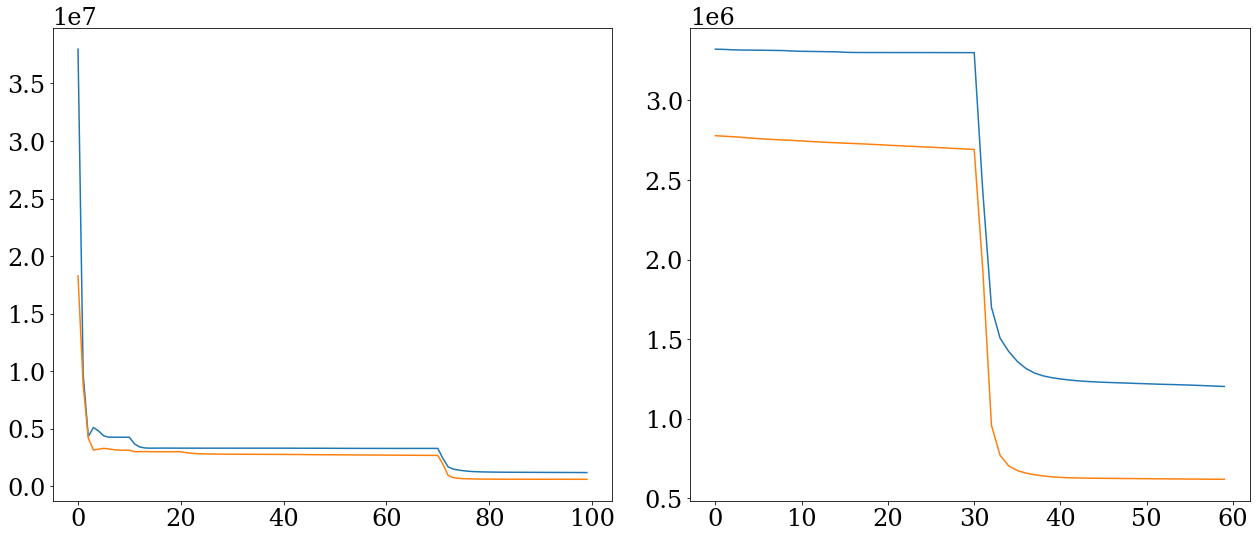

In [ ]:
fig, axs = plt.subplots(1,2, figsize=(18,8))
axs[0].plot(losses_s)
axs[1].plot(losses_s[-60:])
axs[0].plot(losses_b)
axs[1].plot(losses_b[-60:])
fig.tight_layout()

32.288425 32.216957


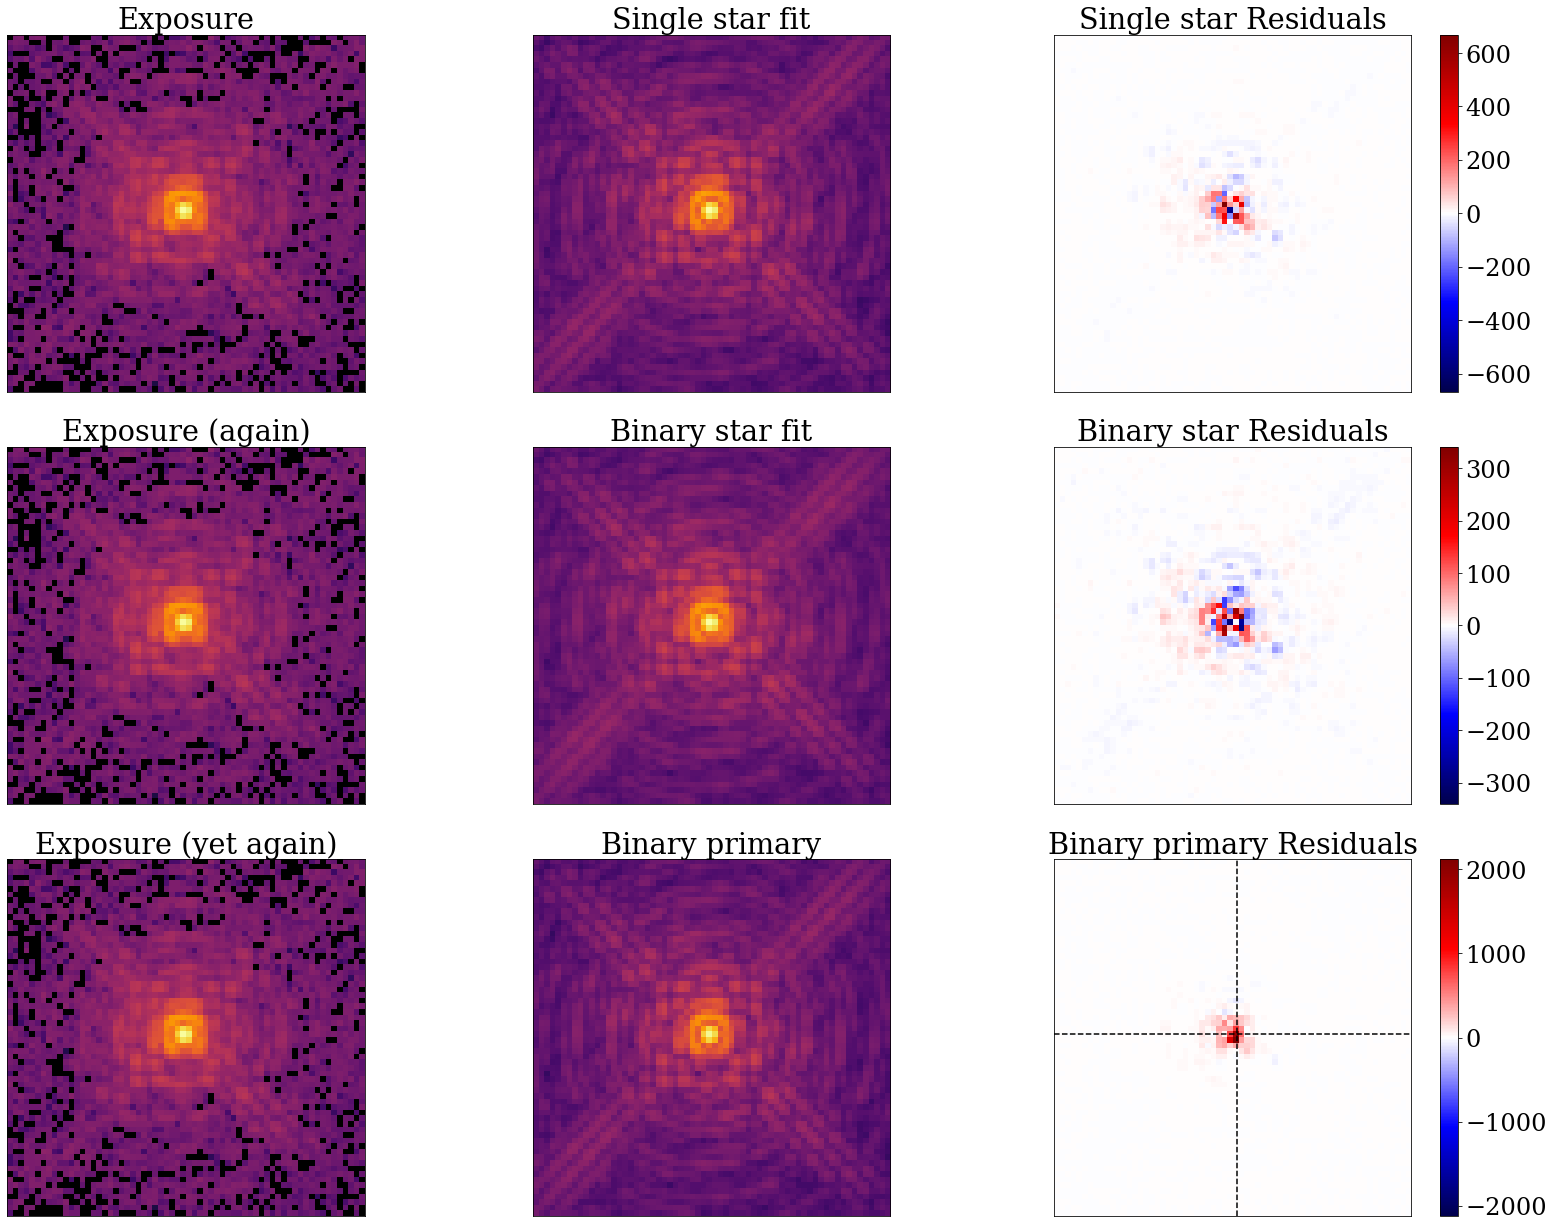

In [ ]:
fig, axs = plt.subplots(3,3,figsize=(30*0.8,22*0.8))

point_model = params_s.inject(point_model)
binary_model = params_b.inject(binary_model)

cmap = matplotlib.colormaps['inferno']
cmap.set_bad('k',1)

ind = 0

coords = dlu.pixel_coords(512, 2.4)
cropped_frame = exposures_s[ind].data**0.125

exposure_s = exposures_s[ind]
exposure_b = exposures_b[ind]

point_frame = exposure_s.fit(point_model, exposure_s)**0.125
binary_frame = exposure_b.fit(binary_model, exposure_b)**0.125

single_resid = (exposure_s.data-exposure_s.fit(point_model, exposure_s))/exposure_s.err
binary_resid = (exposure_b.data-exposure_b.fit(binary_model, exposure_b))/exposure_b.err

vm = max(np.nanmax(cropped_frame),np.nanmax(point_frame), np.nanmax(binary_frame))


axs[0,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[0,1].imshow(point_frame,cmap=cmap, vmin=0, vmax=vm)
rlim = np.nanmax(np.abs(single_resid))
resid = axs[0,2].imshow(single_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[0,2])

axs[1,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[1,1].imshow(binary_frame,cmap=cmap, vmin=0, vmax=vm)

rlim = np.nanmax(np.abs(binary_resid))
resid = axs[1,2].imshow(binary_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[1,2])

#f095n = np.asarray(pd.read_csv("../data/HST_NICMOS1.F095N.dat", sep=' '))

e_filter = binary_model.filters[exposure_b.filter]

wavels = e_filter[:,0]
weights = e_filter[:,1]

positions = dlu.positions_from_sep(
        binary_model.get(exposure_b.map_param("positions")),
        binary_model.params["separation"],
        binary_model.params["position_angle"]
    )

binary_primary_source = dl.PointSource(
    spectrum=dl.Spectrum(wavels,weights),
    position = positions[1],
    flux = dlu.fluxes_from_contrast(
        binary_model.get(exposure_b.map_param("fluxes")),
        binary_model.get(exposure_b.map_param("contrast")),
    )[1]
)

binary_optics = exp.fit.update_optics(binary_model, exp)


binary_primary_system = dl.Telescope(
    binary_optics,
    #binary_model.optics,
    binary_primary_source,
    binary_model.detector
)

binary_primary_frame = binary_primary_system.model()**0.125

axs[2,0].imshow(cropped_frame,cmap=cmap, vmin=0, vmax=vm)
axs[2,1].imshow(binary_primary_frame,cmap=cmap, vmin=0, vmax=vm)

bp_resid = (exposure_b.data-binary_primary_system.model())/exposure_b.err
rlim = np.nanmax(np.abs(bp_resid))
resid = axs[2,2].imshow(bp_resid, vmin=-rlim, vmax=rlim, cmap='seismic')
plt.colorbar(resid,ax=axs[2,2])

x, y = dlu.rad2arcsec(positions[0])/0.042 + wid/2

print(x,y)

axs[2,2].axvline(x, color='k',linestyle='--')
axs[2,2].axhline(y, color='k',linestyle='--')

axs[0,0].set_title("Exposure")
axs[1,0].set_title("Exposure (again)")
axs[2,0].set_title("Exposure (yet again)")

axs[0,1].set_title("Single star fit")
axs[1,1].set_title("Binary star fit")
axs[2,1].set_title("Binary primary")

axs[0,2].set_title("Single star Residuals")
axs[1,2].set_title("Binary star Residuals")
axs[2,2].set_title("Binary primary Residuals")



for i in range(3):
    for j in range(3):
        axs[i,j].set_xticks([])
        axs[i,j].set_yticks([])

fig.tight_layout()


5


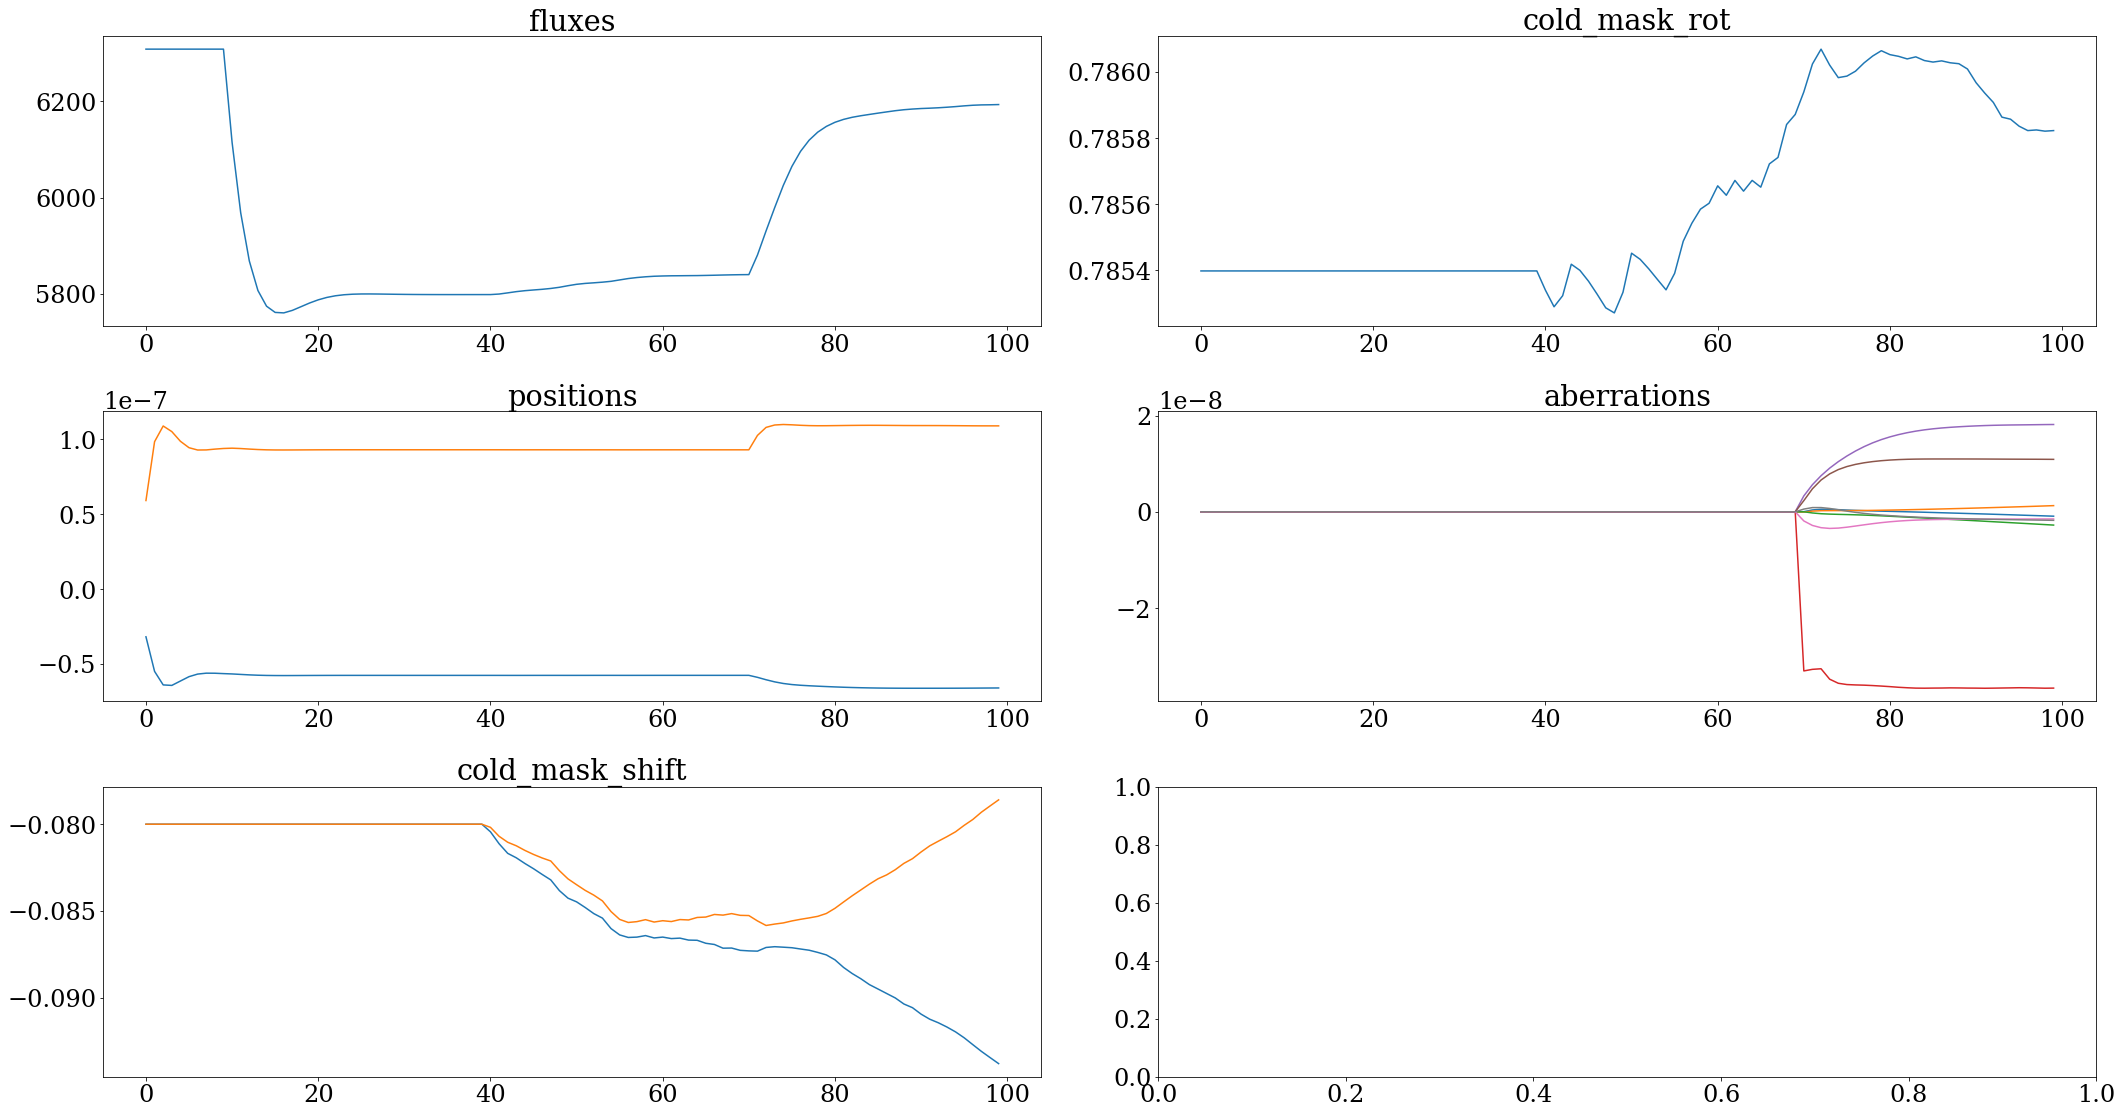

In [ ]:
xw = 3
yw = int(np.ceil(len(groups_s)/xw))

print(len(groups_s))


fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_s):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_s[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_s]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_s])
    
fig.tight_layout()

8


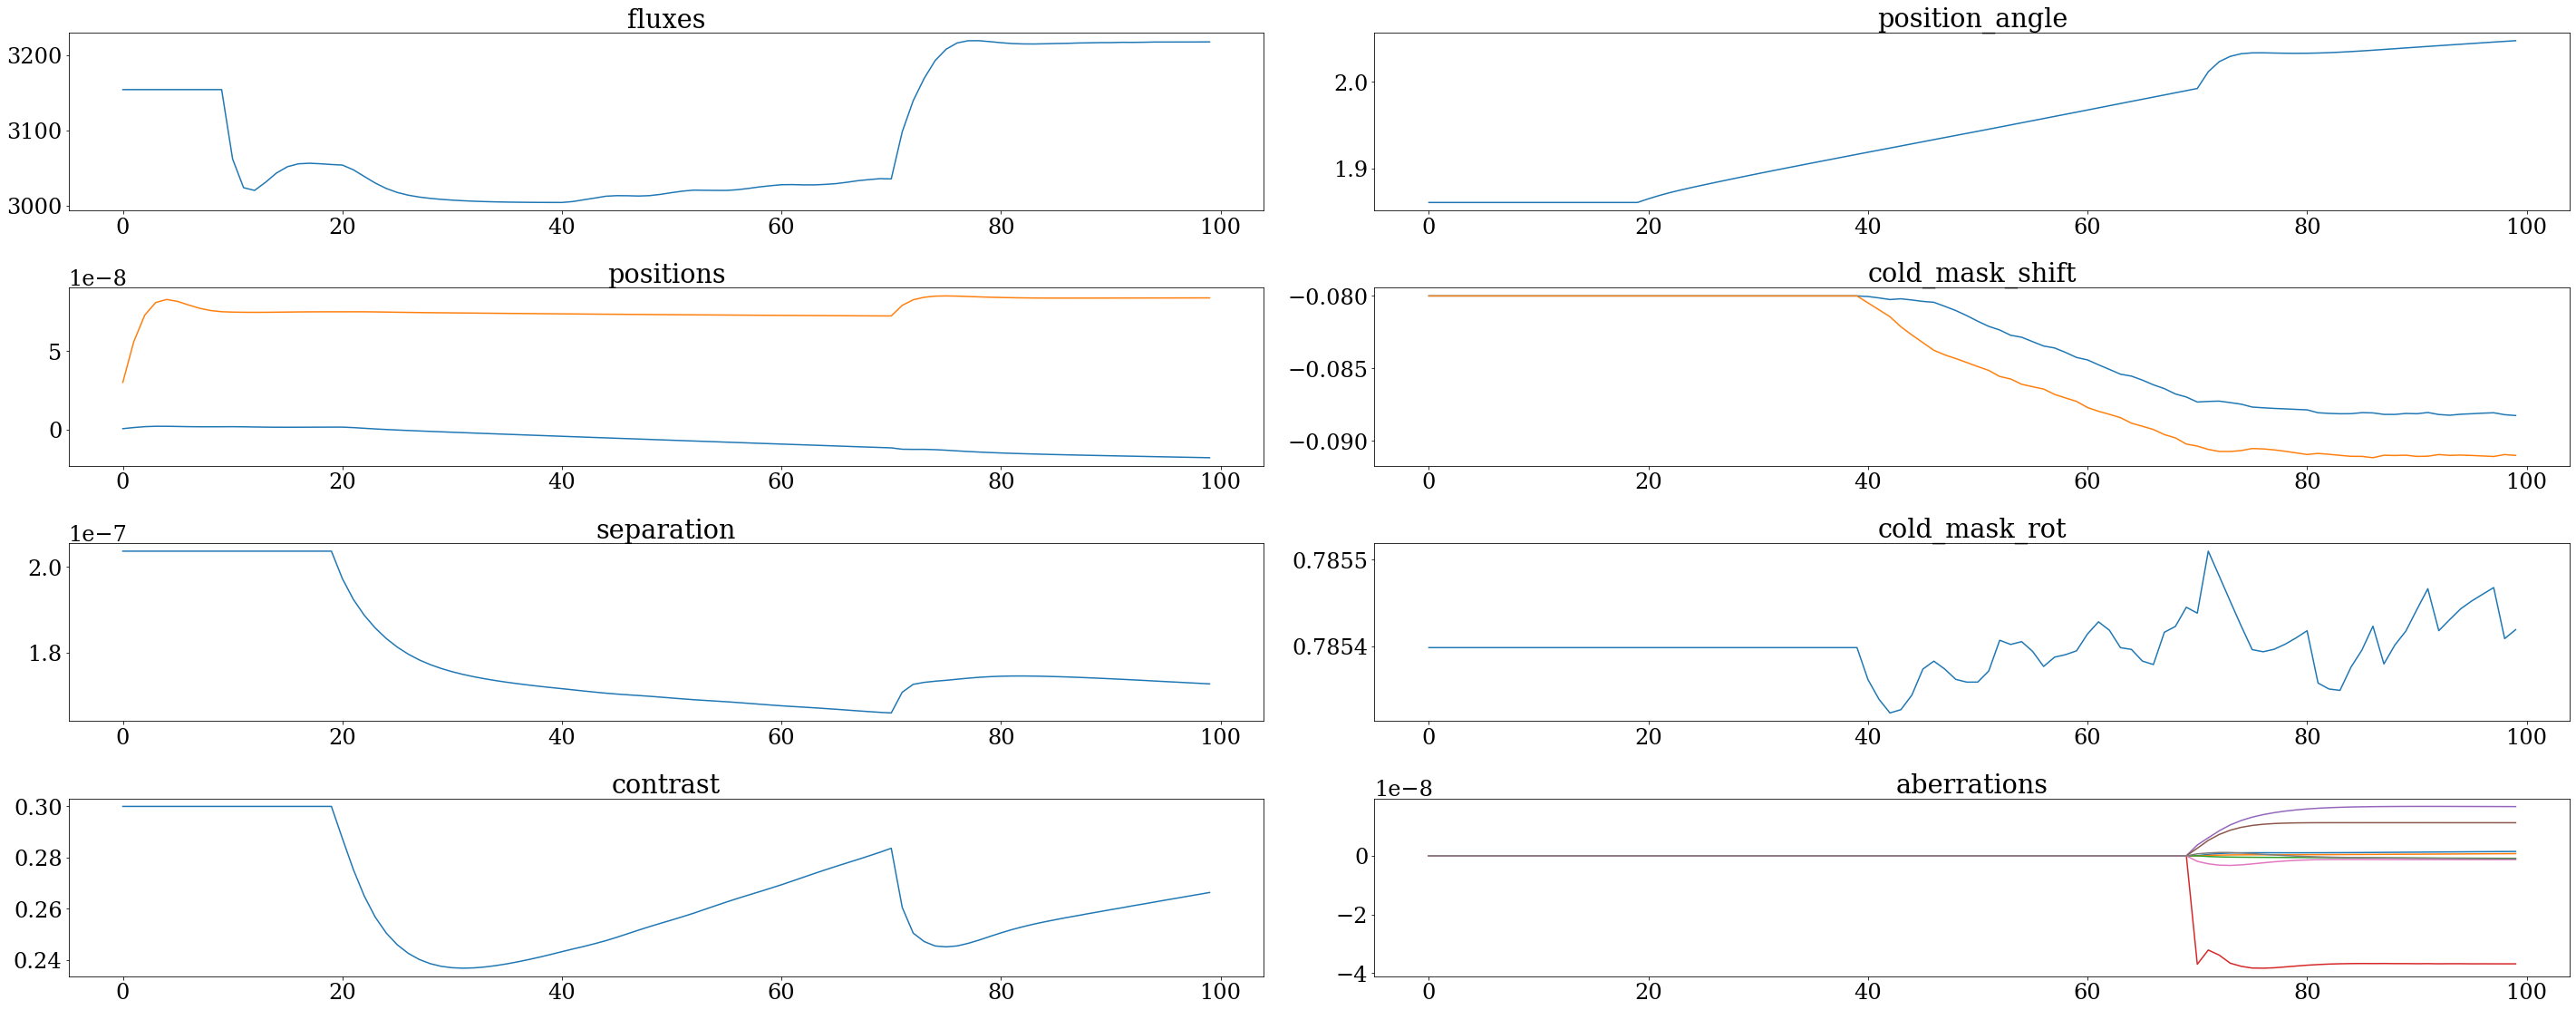

In [ ]:
xw = 4
yw = int(np.ceil(len(groups_b)/xw))

print(len(groups_b))

fig, axs = plt.subplots(xw,yw,figsize=(xw*10,yw*8))
for i, param in enumerate(groups_b):
    #print(param)
    sp = axs[i%xw, i//xw]
    if param in ["fluxes", "contrast", "positions", "aberrations", "cold_mask_shift", "cold_mask_rot"]:
        #print(np.asarray(list(models_b[0].get(param).values())))
        for p in np.asarray([np.asarray(list(x.get(param).values())) for x in models_b]).T:
            if len(p.shape)>1:
                for i in range(p.shape[0]):
                    sp.plot(p[i,:])
            else:
                sp.plot(p)
            sp.set_title(param)
    else:
        sp.set_title(param)
        sp.plot([x.get(param) for x in models_b])
    
fig.tight_layout()

Evidence

In [ ]:
no

NameError: name 'no' is not defined

In [ ]:
print(loss_fn_b(params_b, exposures_b))

(Array(2941479.85204316, dtype=float64), ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    None,
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    None,
    'separation':
    f64[],
    'spider_width':
    f64[]
  }
))


In [ ]:
def loss_fn_b_params(params,exposures):
    model = params.inject(binary_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))

def loss_fn_s_params(params,exposures):
    model = params.inject(point_model)
    return np.nansum(np.asarray([posterior(model,exposure) for exposure in exposures]))


loss_fn_b_params(params_b, exposures_b)

Array(2941479.85204316, dtype=float64)

In [ ]:
binary_model

NICMOSModel(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    1.146,
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    0.44639999999999996,
    'separation':
    f64[],
    'spider_width':
    f64[]
  },
  filters={'F095N': f64[28,2]},
  optics=NICMOSOptics(
    wf_npixels=512,
    diameter=f64[],
    layers={
      'CompoundAperture':
      CompoundAperture(
        normalise=True,
        transformation=None,
        apertures={
          'cold_mask':
          NICMOSColdMask(
            normalise=True,
            transformation=CoordTransform(
              translation=f64[2],
              rotation=f64[],
              compression=None,
              shear=None
            ),
            apertures={
              'oute

In [ ]:
#hessian = jax.hessian(loss_fn_b_params)(params_b, exposures_b)

In [ ]:
rc = True
fishers_s = calc_fishers(point_model, exposures_s, paths_s, recalculate=rc, save=False)

fishers_b = calc_fishers(binary_model, exposures_b, paths_b, recalculate=rc, save=False)


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
fishers_b['N43CA5020']

{'fluxes': Array([[28.61768024]], dtype=float64),
 'positions': Array([[4.27392466e+21, 1.61836184e+20],
        [1.61836184e+20, 5.47737252e+21]], dtype=float64),
 'separation': Array([[9.22736656e+20]], dtype=float64),
 'contrast': Array([[81690839.64723133]], dtype=float64),
 'position_angle': Array([[25962328.6697551]], dtype=float64),
 'cold_mask_shift': Array([[3.57438988e+08, 6.32895827e+08],
        [6.32895827e+08, 2.90697529e+08]], dtype=float64),
 'cold_mask_rot': Array([[-93718581.73790352]], dtype=float64),
 'aberrations': Array([[ 2.60776970e+20,  3.17433087e+20,  8.79853438e+18,
          6.53374877e+20,  4.72160501e+20,  1.70078566e+20,
         -6.53012897e+19,  3.51160589e+20],
        [ 3.17433087e+20, -4.00063541e+20, -1.50799033e+20,
          5.52994399e+20,  3.06464736e+20,  2.12678972e+20,
         -9.53337731e+19,  2.60020859e+20],
        [ 8.79853438e+18, -1.50799033e+20, -9.00730072e+19,
         -6.40232260e+20,  1.86604146e+20, -4.05409431e+19,
         -5

In [ ]:
#hessian.params["contrast"]["N43CA5020"].params["contrast"]["N43CA5020"]

In [ ]:
logdet_s = sum([np.linalg.slogdet(x).logabsdet for x in list(fishers_s['N43CA5020'].values())[:]])
logdet_b = sum([np.linalg.slogdet(x).logabsdet for x in list(fishers_b['N43CA5020'].values())[:]])
print(logdet_s)
print(logdet_b)

567.1283129765442
651.8299858205611


In [ ]:
params_b

ModelParams(
  params={
    'aberrations':
    {'N43CA5020': f64[8]},
    'cold_mask_rot':
    {'N43CA5020': f64[]},
    'cold_mask_shift':
    {'N43CA5020': f64[2]},
    'contrast':
    {'N43CA5020': f64[]},
    'fluxes':
    {'N43CA5020': f64[]},
    'outer_radius':
    1.146,
    'position_angle':
    f64[],
    'positions':
    {'N43CA5020': f64[2]},
    'secondary_radius':
    0.44639999999999996,
    'separation':
    f64[],
    'spider_width':
    f64[]
  }
)

In [ ]:
D_s = 17#sum([len(x) for x in params_s.params['N43CA5020'].values()])
print(D_s)
D_b = 20#sum([len(x) for x in params_b.params['N43CA5020'].values()])


17


In [ ]:
D_s/2 * np.log(2*np.pi) + 1/2 * logdet_s - loss_fn_s_params(params_s, exposures_s)

Array(-3488294.56559687, dtype=float64)

In [ ]:
D_b/2 * np.log(2*np.pi) + 1/2 * logdet_b - loss_fn_b_params(params_b, exposures_b)

Array(-2998320.94172203, dtype=float64)

In [ ]:
print(list(fishers_s['N43CA5020'].keys()))

['fluxes', 'positions', 'cold_mask_shift', 'cold_mask_rot', 'aberrations', 'spider_width']


In [ ]:
np.linalg.slogdet()

TypeError: slogdet() missing 1 required positional argument: 'a'

In [ ]:
def log_det(X):
    mag = np.mean(np.abs(X))
    ld = np.log10(np.abs(np.linalg.det((X)/mag)))
    #print(ld,X/mag)
    return ld + np.log10(mag*X.shape[0])

In [ ]:
vals = np.asarray([log_det(x) for x in list(fishers_s['N43CA5020'].values())])[:-1]
np.sum(vals)+len(vals)/2 * np.log10(np.sqrt(2*np.pi)) + loss_fn_b_params(params_s, exposures_s)/(wid**2)

Array(348.76166, dtype=float32)

In [ ]:
vals = np.asarray([np.linalg.det(np.abs(x)/1e17) for x in list(fishers_s['N43CA5020'].values())])[:-1]
print(vals,len(vals))
le = np.sum(np.log10(np.abs(vals)))
print(le)

[ 6.6596285e-17  2.5060178e+09  5.7386980e-16  3.9659685e-08
 -2.8137976e+31  1.9567434e-08  5.4487179e-09] 7
-13.943282


In [ ]:
#fishers_s
#[[numpy.linalg.det(u.astype(np.float64)) for u in v.values()] if type(v)==dict else numpy.linalg.det(v) for v in fishers_s.values()]